In [1]:
import matplotlib as mpl
import matplotlib.colors as co
import matplotlib.pyplot as plt
import matplotlib.ticker as mt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

mpl.style.use('default')


def read_JAEA(isotope, yield_type, ZNA, file=None):
    """
    Reads data that is obtained from JAEA at:
    https://wwwndc.jaea.go.jp/cgi-bin/FPYfig
    """

    if file is None:
        file = f'{isotope}_{yield_type}_{ZNA}'

    if ZNA == 'ZN':
        noa = 'N'
    elif ZNA == 'ZA':
        noa = 'A'

    df = pd.read_table(file,
                       sep='\s+',
                       skiprows=5,
                       header=None,
                       names=['Z', noa, 'Fission Yield'])

    Z = np.arange(df['Z'].min(), df['Z'].max()+1)
    NA = np.arange(df[noa].min(), df[noa].max()+1)

    fission_yields = df['Fission Yield'].to_numpy()
    fission_yields = np.reshape(fission_yields, (len(Z), len(NA)))

    organized_df = pd.DataFrame(fission_yields, index=Z, columns=NA)
    organized_df.index.name = 'Z'
    organized_df.columns.name = noa

    return organized_df


def log_tick_formatter(val, pos=None):
    """
    This function helps to avoid the bug in setting the 3D plot to logarithmic
    scale, which causes the labels to change but not the ticks and vales,
    so the result is bad.
    """
    return "{:.0e}".format(10**val)


def plot3D(isotope, yield_type, ZNA, config,
           df=None):

    if df is None:
        df = data[isotope][yield_type][ZNA]

    zmin, zmax = config['zmin'], config['zmax']
    color = config['color']

    fig = plt.figure(figsize=config['figsize'])
    ax = Axes3D(fig)

    ax.set_facecolor('w')

    Z = df.index
    NA = df.columns
    NA_mesh, Z_mesh = np.meshgrid(NA, Z)

    filtered_df = df.applymap(lambda value: np.nan if value < zmin else value)

    # BUG WARNING! https://github.com/matplotlib/matplotlib/issues/209
    # We want to plot with Z axis in logarithmic scale, but the usual
    # functionality of setting the axis to log scale is not working.
    # Our option is to apply the log10 to the Z values, renormalize the colors
    # in log scale but later use the custom tick formater function to show
    # labels as actual values (between 1E-10 and 0.1) instead of
    # log10 of values (-10 and -1).
    # Also the filtered_df has to be converted to numpy 2D array, or else the
    # index of the dataframe becomes weird when we apply np.log10 and
    # the plot functions behave incorrectly.
    log_fission_yields = np.log10(filtered_df.to_numpy())
    log_vmin, log_vmax = np.log10(zmin), np.log10(zmax)
    norm = co.Normalize(vmin=log_vmin, vmax=log_vmax)

    zticks = np.logspace(log_vmin, log_vmax, num=10)
    ax.zaxis.set_major_formatter(mt.FuncFormatter(log_tick_formatter))

    # Start plotting
    surf = ax.plot_surface(NA_mesh, Z_mesh, log_fission_yields,
                           cmap=color,
                           norm=norm,
                           linewidth=1,
                           antialiased=False)

    if ZNA == 'ZN':
        ax.set_xlabel('Neutron Number')
    elif ZNA == 'ZA':
        ax.set_xlabel('Nucleons')
    ax.set_ylabel('Atomic Number')
    ax.set_zlabel('Fission Yield', labelpad=10)

    ax.contourf(NA_mesh, Z_mesh, log_fission_yields,
                zdir='z',
                offset=log_vmin,
                cmap=color,
                norm=norm)

    cbar = plt.colorbar(surf, shrink=0.6, aspect=10)
    cbar.ax.set_yticklabels(["{:.0e}".format(val) for val in zticks])

    E = isotope.rstrip('0123456789')
    A = isotope[len(E):]
    AL = '{' + A + '}'

    plt.title(f'$^{AL}${E} {yield_type} Fission Yield at 0.0253 eV')

    plt.savefig(f'{isotope}_{yield_type}_{ZNA}_3D.pdf')


def heatmap(isotope, yield_type, ZNA, config,
            df=None,
            annotated=False,
            mark_DNP=False):

    if df is None:
        df = data[isotope][yield_type][ZNA]

    vmin, vmax = plot_config['zmin'], plot_config['zmax']
    color = plot_config['color']

    log_norm = co.LogNorm(vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(figsize=plot_config['figsize'])

    def get_edges(intervals):
        edges = intervals.to_numpy() - 0.5
        edges = np.append(edges, edges[-1] + 1)
        return edges

    NA_edges, Z_edges = get_edges(df.columns), get_edges(df.index)

    heatmap = ax.pcolor(NA_edges, Z_edges, df[df > vmin],
                        cmap=color,
                        norm=log_norm,
                        edgecolors='black')

    ax.xaxis.set_minor_locator(mt.MultipleLocator(1))
    ax.yaxis.set_minor_locator(mt.MultipleLocator(1))
    ax.set_axisbelow(True)
    ax.grid(which='both')

    if ZNA == 'ZN':
        ax.set_xlabel('Neutron Number')
    elif ZNA == 'ZA':
        ax.set_xlabel('Nucleons')
    ax.set_ylabel('Atomic Number')

    plt.colorbar(heatmap,
                 ticks=np.logspace(np.log10(vmin), np.log10(vmax), num=10))

    E = isotope.rstrip('0123456789')
    A = isotope[len(E):]
    AL = '{' + A + '}'

    plt.title(f'$^{AL}${E} {yield_type} Fission Yield at 0.0253 eV')

    save_name = f'{isotope}_{yield_type}_{ZNA}_HM'

    if annotated:
        save_name += '_annotated'
        value_to_color = mpl.cm.ScalarMappable(norm=log_norm, cmap='Greys')

        for na in df.columns:
            for z in df.index:
                val = df.at[z, na]
                if val > vmin:
                    plt.text(na, z, '%.2e' % val,
                             color=value_to_color.to_rgba(val),
                             fontsize=1.2,
                             horizontalalignment='center',
                             verticalalignment='center',
                             )

    if mark_DNP:
        save_name += '_DNP'
        for key, values in DNP[ZNA].items():
            diff_values = np.diff(values)
            split_index = np.where(diff_values > 1)[0]
            split_values = np.split(values, split_index+1)

            for interval in split_values:
                na_n = np.array(interval) - 0.5
                na_p = np.array(interval) + 0.5
                na_edges = np.unique(np.concatenate([na_n, na_p]))
                ax.fill_between(na_edges, key - 0.5, key + 0.5,
                                fc='none', ec='k', hatch='////')

    plt.savefig(save_name + '.pdf',
                bbox_inches='tight',
                transparent=True,)



Here we import data that is available automatically for plotting and everything else.

We also define a function to plot all standard data if that is desired.

In [2]:
# Standard data automatically available
isotopes = ['U233', 'U235', 'Pu239']
yield_types = ['IND', 'CUM']
ZNA = ['ZN', 'ZA']

# Nested dictionary that is accessed as
# data[isotopes][yield_types][ZNA]
# each element is a dataframe with Z index, and N or A columns
data = {I: {yt: {zna: read_JAEA(I, yt, zna)
                 for zna in ZNA} for yt in yield_types} for I in isotopes}

def plot_everything():
    for isotope in isotopes:
        for yield_type in yield_types:
            for zna in ZNA:
                plot3D(isotope, yield_type, zna, plot_config)
                heatmap(isotope, yield_type, zna, plot_config)

For example, below we access the data for Independent Fission Product Yields of U235 with 92 nucleons.

In [3]:
data['U235']['IND']['ZA'][92]

Z
23    1.000000e-30
24    1.000000e-30
25    1.000000e-30
26    1.000000e-30
27    1.000000e-30
28    1.000000e-30
29    1.000000e-30
30    1.000000e-30
31    1.000000e-30
32    1.000000e-30
33    3.557180e-12
34    4.180880e-07
35    2.684310e-04
36    1.662560e-02
37    3.140150e-02
38    1.078070e-02
39    7.167500e-04
40    1.193020e-04
41    7.842190e-14
42    1.000000e-30
43    1.000000e-30
44    1.000000e-30
45    1.000000e-30
46    1.000000e-30
47    1.000000e-30
48    1.000000e-30
49    1.000000e-30
50    1.000000e-30
51    1.000000e-30
52    1.000000e-30
53    1.000000e-30
54    1.000000e-30
55    1.000000e-30
56    1.000000e-30
57    1.000000e-30
58    1.000000e-30
59    1.000000e-30
60    1.000000e-30
61    1.000000e-30
62    1.000000e-30
63    1.000000e-30
64    1.000000e-30
65    1.000000e-30
66    1.000000e-30
67    1.000000e-30
68    1.000000e-30
69    1.000000e-30
70    1.000000e-30
71    1.000000e-30
Name: 92, dtype: float64

Here we define which isotopes are Delayed Neutron Precursors (DNPs).
This list comes from the "Handbook of Nuclear Reactor Calculations", volume 2, page 259.

The list of DNPs is not well defined, but the ones shown should account for more than 95%+ of all delayed neutrons generated.

In [4]:
# HNRC Vol2 Pg259
# DNP responsible for 95%+ of DN
DNP = {'ZA': {31: [79, 80, 81, 82],
              33: [84, 85, 86, 87],
              34: [87, 88, 89, 91],
              35: [87, 88, 89, 90, 91, 92],
              36: [92, 93, 94],
              37: [92, 93, 94, 95, 96, 97, 98],
              38: [97, 98],
              39: [98, 99],
              49: [127, 128, 129, 130, 131, 132],
              50: [134],
              51: [134, 135, 136],
              52: [136, 137, 138],
              53: [137, 138, 139, 140, 141],
              54: [141, 142],
              55: [141, 142, 143, 144, 145, 146],
              56: [147, 148],
              57: [147]},
       'ZN': {}
       }

for key, values in DNP['ZA'].items():
    N = np.array(values) - key
    DNP['ZN'][key] = N


## Plotting

/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator


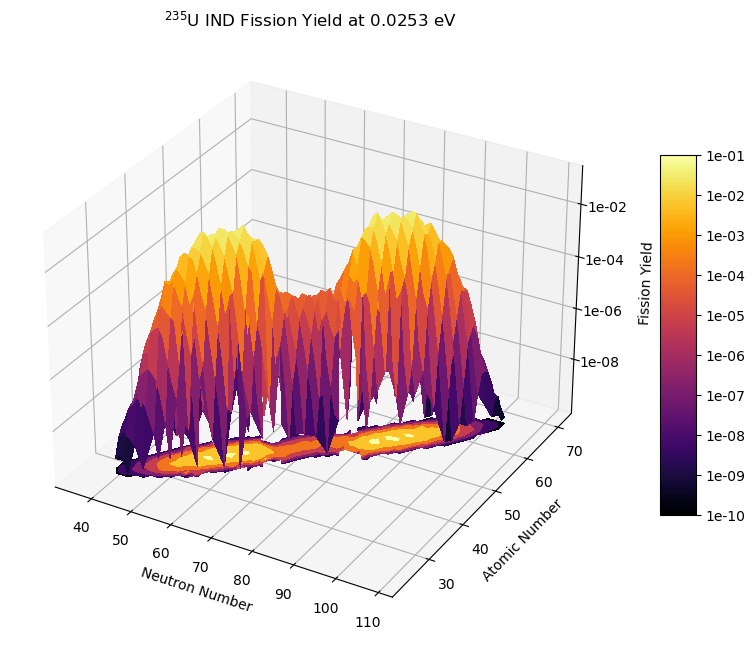

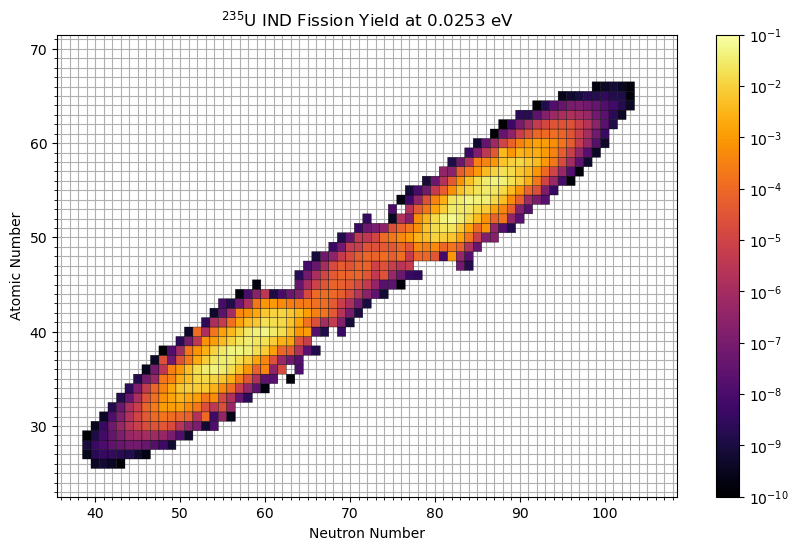

In [5]:
# Default plot configurations
plot_config = {'figsize': (10, 6),
               'zmin': 1E-10,
               'zmax': 1E-1,
               'color': 'inferno'}

isotope = 'U235'
yield_type = 'IND'
zna = 'ZN'

plot3D(isotope, yield_type, zna, plot_config)
heatmap(isotope, yield_type, zna, plot_config)

We can also plot some special heatmaps that are marked for delayed neutron precursors or that have the value of the yield in the cell (it's very small, so you have to open the pdf image and zoom where you want)

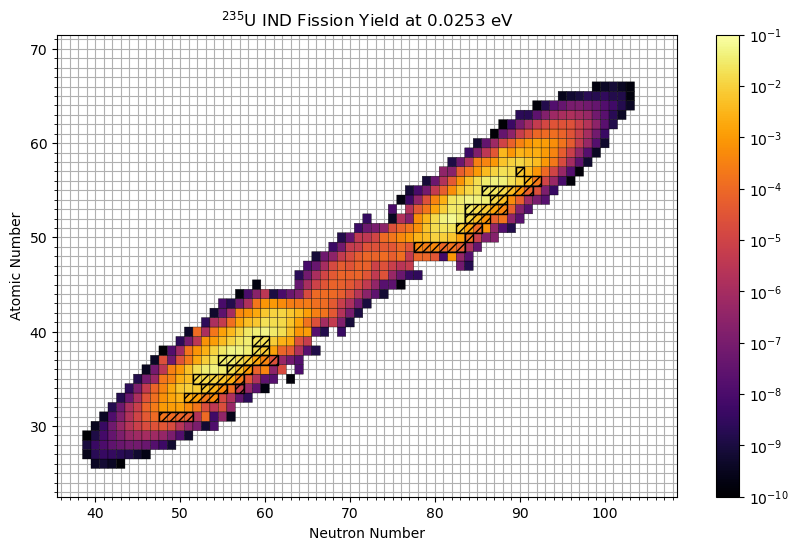

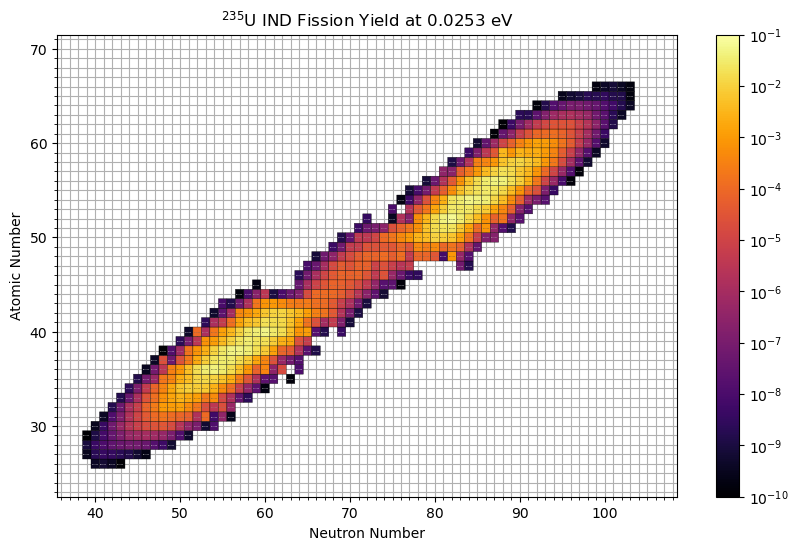

In [6]:
heatmap(isotope, yield_type, zna, plot_config, mark_DNP=True)
heatmap(isotope, yield_type, zna, plot_config, annotated=True)

We can also read and plot an isotope that is not in the standard data.

/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator


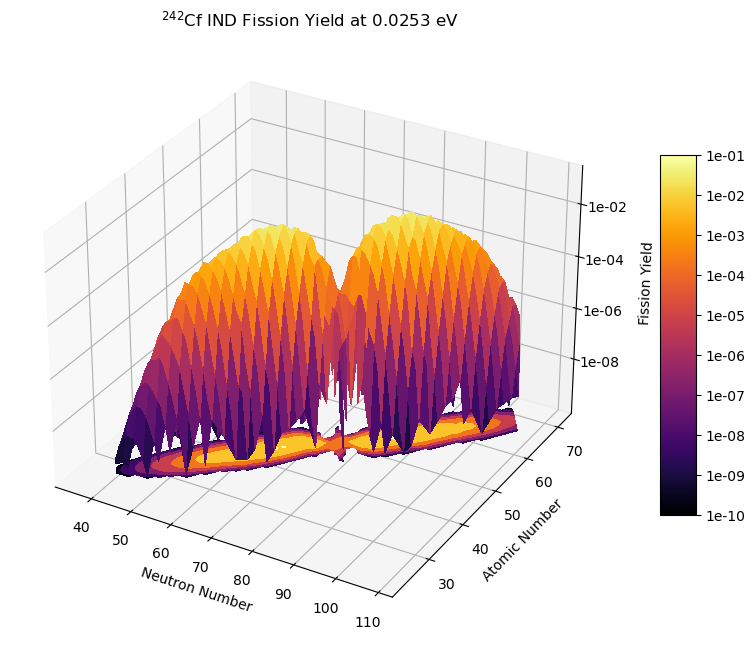

In [7]:
isotope = 'Cf242'
yield_type = 'IND'
zna = 'ZN'

Cf242 = read_JAEA('Cf242', 'IND', 'ZN', file='Cf242')
plot3D(isotope, yield_type, zna, plot_config, df=Cf242)

In [8]:
#plot_everything()

Bokeh is another visualisation library that can plot graphs, such as the heatmap. Unlike Matplolib, it can do so in a interactive way as well, so it is interesting to experiment with it.

We shall use one of the isotope dataframes above and plot an interactive heatmap of fission yield.
The tricky part about Bokeh is that it doesn't play nearly as nicely with dataframes as matplotlib does, which is probably related to its interative capabilities (based on JavaScript).

So the way to solve this is to turn the Pandas Dataframe into a Bokeh ColumnDataSource, which ironically has exactly the same format of the data that we first imported and had to do some manipulation to organize into a Dataframe. Regardless, we are not going to re-import it. Instead, we will turn the dataframe back into that original format using the "unpivot" function.

In [9]:
from bokeh.io import output_notebook, show
from bokeh.models import BooleanFilter, CDSView, ColorBar, ColumnDataSource, LogColorMapper, LogTicker
from bokeh.plotting import figure
from bokeh.transform import transform

output_notebook()

def unpivot(frame):
    Z, NA = frame.shape
    data = {
        "FY": frame.to_numpy().ravel(),
        "Z": np.asarray(frame.index).repeat(NA),
        "NA": np.tile(np.asarray(frame.columns), Z)
    }
    return pd.DataFrame(data, columns=["Z", "NA", "FY"])

u_df = unpivot(Cf242)
print(u_df)

Loading BokehJS ...

       Z   NA            FY
0     23   36  1.000000e-30
1     23   37  1.000000e-30
2     23   38  1.000000e-30
3     23   39  1.000000e-30
4     23   40  1.000000e-30
...   ..  ...           ...
3572  71  104  1.000000e-30
3573  71  105  1.000000e-30
3574  71  106  1.000000e-30
3575  71  107  1.000000e-30
3576  71  108  1.000000e-30

[3577 rows x 3 columns]


Now we turn the unpivoted Dataframe into the ColumnDataSource.

We also create a boolean filter where we mark what is above the minimum limit. Then we use this to filter the Dataframe. This is because we don't want to plot dummy isotopes, which are isotopes that got fission yields of E-30 so that JAEA (original source of the data we use) could use it to plot on GNUplot. We could also use the RAW data in the future.

In [10]:
source = ColumnDataSource(u_df)

print(source)

booleans = [True if FY >= plot_config['zmin'] else False for FY in source.data['FY']]
view = CDSView(source = source, filters=[BooleanFilter(booleans)])

ColumnDataSource(id='1003', ...)


Now we plot everything into that nice interactive heatmap.

In this graph, if you hover the mouse pointer on top of a reactangle representing an isotope, you get a small popup with numeric data from the isotope, which is very neat for the small amount of lines that was required.

In [11]:
mapper = LogColorMapper(palette='Inferno256', low=plot_config['zmin'], high=1E-1)

TOOLTIPS = [
    ("Fission Yield (Independent)", "@FY"),
    ("Atomic number", "@Z"),
    ("Neutron number", "@NA")
]

p = figure(width=700, height=500, match_aspect=True,
           #x_range=[str(x) for x in df.columns] , y_range=[str(x) for x in df.index],
           title='Cf242 Independent Fission Yield',
           tools="hover", toolbar_location=None, tooltips=TOOLTIPS)

p.rect(x='NA', y='Z', width=1, height=1, source=source, view=view,
       line_color='Black', fill_color=transform('FY', mapper),
       hover_color="green")
p.xaxis[0].axis_label = 'Neutron number'
p.yaxis[0].axis_label = 'Atomic number'

color_bar = ColorBar(color_mapper=mapper,
                     ticker=LogTicker())

p.add_layout(color_bar, 'right')

show(p)